Importing Required Packages

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2 as cv
import os
from math import sqrt
from statistics import mean
%matplotlib inline

Various Functions Used

In [12]:
# Creating trackbars for parameter tuning
def parameterTuning():
    
    def nothing(x):
        return None

    cv.namedWindow('Parameter Tuning')
    cv.createTrackbar('rho', 'Parameter Tuning', 1 , 30, nothing)
    cv.createTrackbar('min_line_length', 'Parameter Tuning', 1 , 400, nothing)
    cv.createTrackbar('max_line_gap', 'Parameter Tuning', 1 , 400, nothing)
    cv.createTrackbar('threshold', 'Parameter Tuning', 1 , 200, nothing)

# Position of trackbar is stored
def trackbarPos():
    global rho
    global min_line_length
    global max_line_gap
    global threshold
    
    rho = cv.getTrackbarPos('rho', 'Parameter Tuning')
    min_line_length = cv.getTrackbarPos('min_line_length', 'Parameter Tuning')
    max_line_gap = cv.getTrackbarPos('max_line_gap', 'Parameter Tuning')
    threshold = cv.getTrackbarPos('threshold', 'Parameter Tuning')
    
# Creates ROI 
def ROI(image):
    mask = np.zeros_like(image) # creating a black image of size provided as argument
    vertices = np.array([[(100,539),(420,335), (540,335), (940,539)]], np.int32) # vertices of the polygon for roi
    #cv.polylines(edges, vertices, True, (0,255,0), thickness=3) # for visualization of polygon
    cv.fillPoly(mask, vertices, 255) # filling the roi with white pixels in efforts to extract the particular region
    global roi
    roi = cv.bitwise_and(mask, image) # AND operation with the canny edge image

# Draws single Lane Lines from bottom of roi to the top without any gaps on both lanes
def drawLines():
    
    rho = 1 # distance from..
    theta = np.pi/180 # angle..
    threshold = 30 # Number of intersecting lines in hough space, these lines are pts in original space that lie on the same line
    min_line_length = 40 # length in pixels required to be considered as a line 
    max_line_gap = 100 # maximum gap in pixels between subsequent line segments for them to be considered as one line
    global lane_marked
    global prev_intercept_right   
    global prev_slope_right
    global prev_intercept_left   
    global prev_slope_left 
    lane_marked = lanes.copy() # copy of original image for creating lines
    lines = cv.HoughLinesP(roi, rho, theta, threshold, np.array([]), min_line_length, max_line_gap) # Houghline transform returns the lines 
    right_slope = []
    right_intercept = []
    left_slope = []
    left_intercept = []
    y_top = 335
    y_bottom = 539
    i = 0
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            intercept = y1 - (slope*x1)
            
            if slope>=0 and (slope<=0.2 or slope>=0.87):
                continue
            elif slope<0 and (slope>-0.2 or slope<-0.87):
                continue
            
            if slope>0:
                left_intercept.append(intercept)
                left_slope.append(slope)
            else:
                right_intercept.append(intercept)
                right_slope.append(slope)
            
    # for right lane
    right_intercept_avg = mean(right_intercept)
    right_slope_avg = mean(right_slope)
    
    xtop_right = (y_top - right_intercept_avg)/right_slope_avg
    xbottom_right = (y_bottom - right_intercept_avg)/right_slope_avg

    # for left lane
    left_intercept_avg = mean(left_intercept)
    left_slope_avg = mean(left_slope)
    
    xtop_left = (y_top - left_intercept_avg)/left_slope_avg
    xbottom_left = (y_bottom - left_intercept_avg)/left_slope_avg 
        
    # drawing lines
    cv.line(lane_marked, (int(xtop_left), y_top), (int(xbottom_left), y_bottom), (255,0,0), 10)
    cv.line(lane_marked, (int(xtop_right), y_top), (int(xbottom_right), y_bottom), (255,0,0), 10)    
    
    
# Adds original image and lane marked image to lower the intensity of the line marking
def reduceLineIntensity():
    original = lanes.copy()
    global lane_blended
    lane_blended = cv.addWeighted(lane_marked, 0.5, original, 0.5, 0) 

# Shows all significant results
def show():
    #cv.imshow('edges', edges)
    #cv.imshow('lane', lanes)
    cv.imshow('roi', roi)
    cv.imshow('Lanes Marked', lane_blended)

Main Pipeline
1. Converting to Grayscale.
2. Blurring the image using Gaussian Filter.
3. Using Canny edge detection methods to find lane edges.
4. Finding and ROI around road lane area to be detected.
5. Using Houghline Transform converting series of points to a line in hough space and finding the intersection of those lines which in coordinate space infer all the points on the same slope. Finding such two longest lines.
6. Decresing the weight of the marked lines for better visibillity


/home/blackpanther/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
/home/blackpanther/.local/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/blackpanther/.local/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much mem

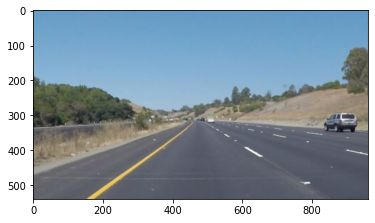

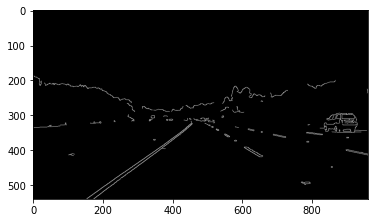

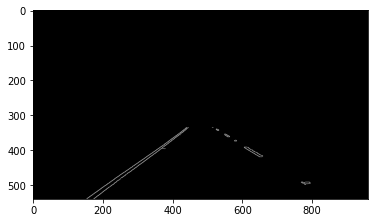

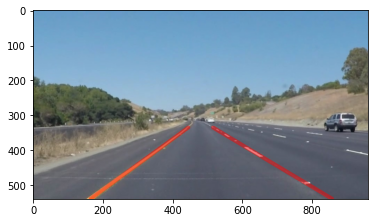

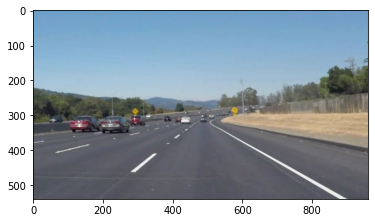

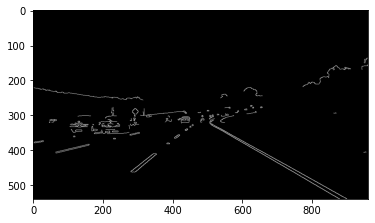

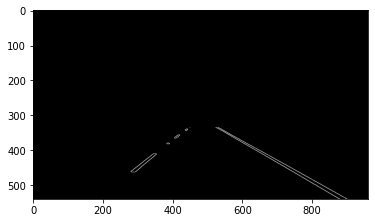

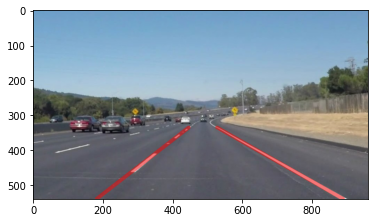

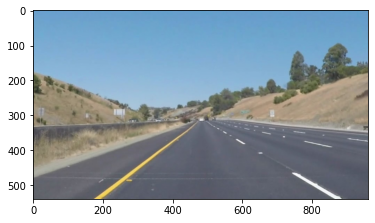

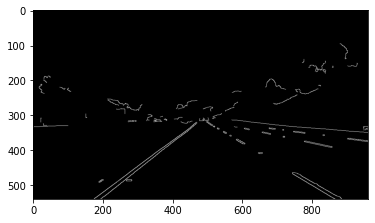

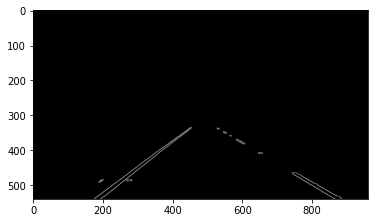

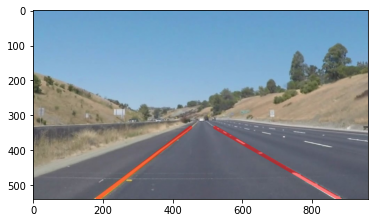

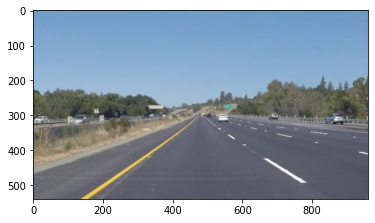

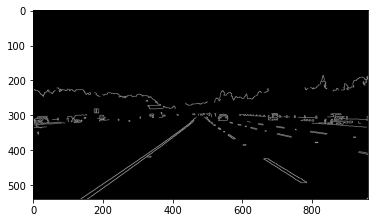

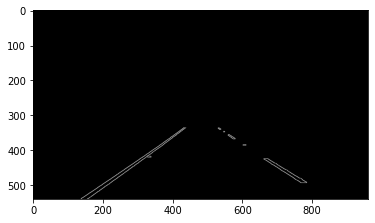

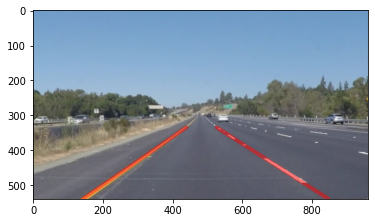

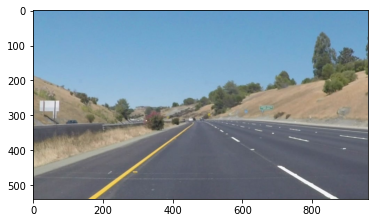

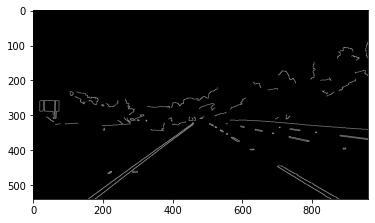

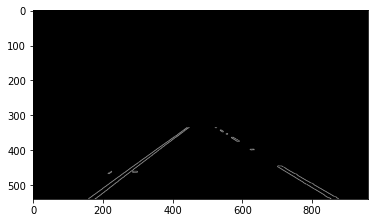

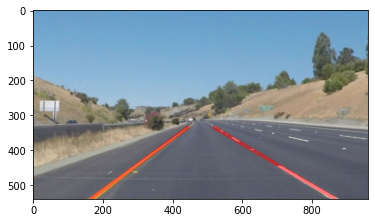

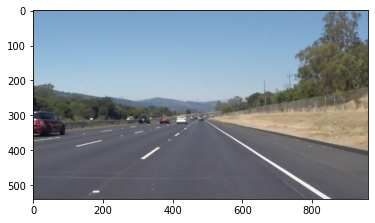

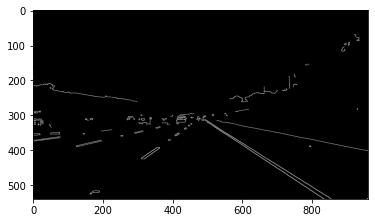

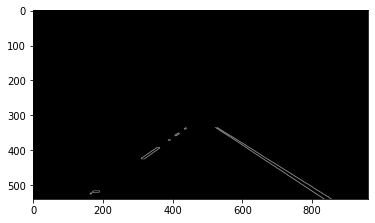

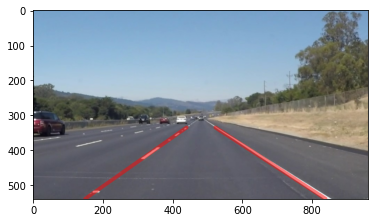

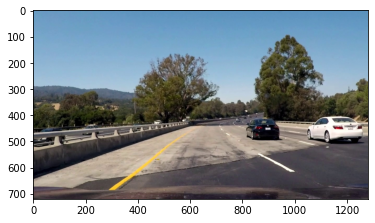

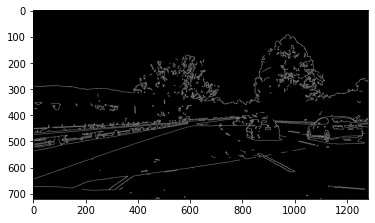

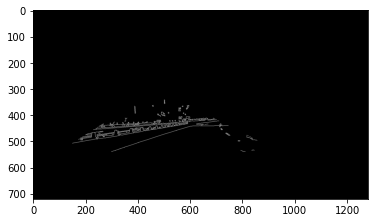

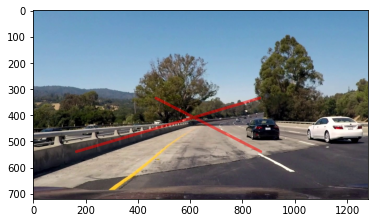

In [20]:
# Reading image files
path_folder = 'test_images'
path_output = 'test_images_output'

for files in os.listdir(path_folder):
    
    lanes = cv.imread(path_folder + "/" + files)
    lanes = cv.cvtColor(lanes, cv.COLOR_BGR2RGB)
    plt.figure()
    plt.imshow(lanes)
    
#print(lanes.shape)

#parameterTuning()

    #Converting to grayscale for edge detection
    grey = cv.cvtColor(lanes, cv.COLOR_BGR2GRAY)

    #Blurring image for better edge detection
    kernel = 1 # kernel size for blurring operation
    gaussBlur = cv.GaussianBlur(grey, (kernel,kernel), 0)

    #Best threshold values found after tuning on multiple test images.
    lowerThreshold = 150 # below which..
    upperThreshold = 300 # above which..
    #cv.line(gaussBlur,(140,539),(225,539),(255,0,0),5)
    #cv.line(gaussBlur,(890,539),(800,539),(255,0,0),5)
    edges = cv.Canny(gaussBlur, lowerThreshold, upperThreshold)
    plt.figure()
    plt.imshow(edges, cmap='gray')
    
    #Lane ROI extraction
    ROI(edges)
    plt.figure()
    plt.imshow(roi, cmap='gray')
    
    # Drawing the longest lines for each lane
    drawLines()
    
    # Reducing Intensity of the drawn lines
    reduceLineIntensity()
    plt.figure()
    plt.imshow(lane_blended)
    
    #saving annotated images
    cv.imwrite(path_output + "/" + files, lane_blended)
    
    

Applying Pipeline on Video Files
1.solidYellowLeft.mp4

In [16]:
vid = cv.VideoCapture('test_videos/solidYellowLeft.mp4')

frame_width = int(vid.get(3))
frame_height = int(vid.get(4))
out = cv.VideoWriter('test_video_output/solidYellowLeft_output.mp4', cv.VideoWriter_fourcc('M','J','P','G'), 30, (frame_width,frame_height))


Applying Pipeline on Video Files
2.solidWhiteRight.mp4

In [18]:
vid = cv.VideoCapture('test_videos/solidWhiteRight.mp4')

frame_width = int(vid.get(3))
frame_height = int(vid.get(4))
out = cv.VideoWriter('test_video_output/solidWhiteRight_output.mp4', cv.VideoWriter_fourcc('M','J','P','G'), 30, (frame_width,frame_height))

Applying Pipeline on Video Files
3.challenge.mp4

In [29]:
vid = cv.VideoCapture('test_videos/challenge.mp4')

frame_width = int(vid.get(3))
frame_height = int(vid.get(4))
out = cv.VideoWriter('test_video_output/challenge_output.mp4', cv.VideoWriter_fourcc('M','J','P','G'), 30, (frame_width,frame_height))

In [19]:
prev_intercept_right = 0  
prev_slope_right = 0
prev_intercept_left = 0  
prev_slope_left = 0

while (vid.isOpened()):
    
    ret, lanes = vid.read()
    #cv.imwrite('challenge_img.jpg', lanes)
    #trackbarPos()
    if ret == True:
        grey = cv.cvtColor(lanes, cv.COLOR_BGR2GRAY)

        #Blurring image for better edge detection
        kernel = 1 # kernel size for blurring operation
        gaussBlur = cv.GaussianBlur(grey, (kernel,kernel), 0)
        
        #Best threshold values found after tuning on multiple test images.
        lowerThreshold = 150 # below which..
        upperThreshold = 300 # above which..
        #cv.line(gaussBlur,(130,539),(225,539),(255,0,0),5)
        #cv.line(gaussBlur,(890,539),(800,539),(255,0,0),5)
        edges = cv.Canny(gaussBlur, lowerThreshold, upperThreshold)

        ROI(edges)

        drawLines()

        reduceLineIntensity()

        show()
        out.write(lane_blended)

    #cv.imwrite('/home/blackpanther/Desktop/Projects/sdr_projects/lane_finder/test_images_output/solidWhiteCurve_output.jpg', lane_blended)
    # Exiting the loop
        k = cv.waitKey(25) & 0xFF
        if k == 27:
            break
    else:
        break
vid.release()
cv.destroyAllWindows()